In [136]:
# !pip install -q git+https://github.com/tensorflow/docs

In [202]:
import os
import cv2
import json
import time
import math
import copy
import random
import imageio
import mediapipe as mp

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow_docs.vis import embed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization

In [2]:
three_dim_encoded_train_data = np.load("../train_data/encoded_data/three_dim_encoded_train_data.npy")
train_labels = np.load("../train_data/pose_train_labels.npy")

In [3]:
print(f"Three dimensional encoded train data shape: {three_dim_encoded_train_data.shape}")
print(f"Train labels shape:                         {train_labels.shape}")

Three dimensional encoded train data shape: (40, 30, 337)
Train labels shape:                         (40,)


In [4]:
three_dim_encoded_val_data = np.load("../val_data/encoded_data/three_dim_encoded_val_data.npy")
val_labels = np.load("../val_data/pose_val_labels.npy")

In [5]:
print(f"Three dimensional encoded val data shape: {three_dim_encoded_val_data.shape}")
print(f"Val labels shape:                         {val_labels.shape}")

Three dimensional encoded val data shape: (17, 30, 337)
Val labels shape:                         (17,)


In [6]:
train_labels_str = np.array(["Good dribbling pose" if x==0 else "Good juggling pose" for x in train_labels])
val_labels_str = np.array(["Good dribbling pose" if x==0 else "Good juggling pose" for x in val_labels])

In [7]:
train_labels_df = pd.DataFrame({"tag": train_labels_str})
train_labels_df.head()

,tag
0,Good dribbling pose
1,Good dribbling pose
2,Good dribbling pose
3,Good dribbling pose
4,Good dribbling pose


In [8]:
def process_label(data):    
    label_processor = keras.layers.StringLookup(
        num_oov_indices=0, vocabulary=np.unique(data)
    )
    
    return label_processor

In [9]:
train_label_processor = process_label(train_labels_df["tag"])
train_label_processor.get_vocabulary()

['Good dribbling pose', 'Good juggling pose']

In [10]:
three_dim_encoded_train_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Train a Standard CNN-LSTM Model with Encoded Data

In [35]:
def standard_cnn_lstm():    
    input_shape = three_dim_encoded_train_data.shape   
    inputs = keras.Input(shape=(input_shape[1:]))
    
    conv = keras.layers.Conv1D(8, 3, activation='relu')(inputs)
    lstm = keras.layers.LSTM(16, return_sequences=True, activation='relu')(conv)
    lstm = keras.layers.LSTM(32, return_sequences=False, activation='relu')(lstm)
    outputs = keras.layers.Dense(1, activation='sigmoid')(lstm)
    cnn_lstm_model = keras.Model(inputs, outputs)
    
    # Compile the model
    cnn_lstm_model.compile(
        loss="binary_crossentropy", 
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )
    
    return cnn_lstm_model

In [36]:
standard_cnn_lstm_model = standard_cnn_lstm()
standard_cnn_lstm_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 30, 337)]         0         
                                                                 
 conv1d_7 (Conv1D)           (None, 28, 8)             8096      
                                                                 
 lstm_14 (LSTM)              (None, 28, 16)            1600      
                                                                 
 lstm_15 (LSTM)              (None, 32)                6272      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,001
Trainable params: 16,001
Non-trainable params: 0
_________________________________________________________________


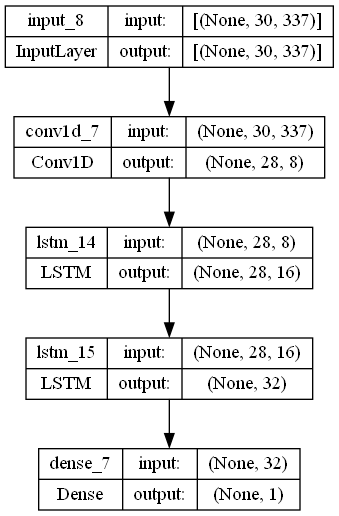

In [37]:
keras.utils.plot_model(standard_cnn_lstm_model, show_shapes=True)

In [38]:
def run_standard_experiment():      
    standard_cnn_lstm_model = standard_cnn_lstm()     
    
    checkpoint_filepath = "training_cp/cp"
    checkpoint_dir = os.path.dirname(checkpoint_filepath)
    
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True
    )
    
    history = standard_cnn_lstm_model.fit(
        three_dim_encoded_train_data,
        train_labels, 
        validation_data=(three_dim_encoded_val_data, val_labels),
        epochs=200,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
        ]
    )
    
    return history, standard_cnn_lstm_model

In [77]:
standard_cnn_lstm_history, standard_cnn_lstm_model = run_standard_experiment()

Epoch 1/200
2/2 [==============================] - 3s 554ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6928 - val_accuracy: 0.6471
Epoch 2/200
2/2 [==============================] - 0s 121ms/step - loss: 0.6929 - accuracy: 0.6750 - val_loss: 0.6928 - val_accuracy: 0.7059
Epoch 3/200
2/2 [==============================] - 0s 118ms/step - loss: 0.6927 - accuracy: 0.6750 - val_loss: 0.6926 - val_accuracy: 0.7059
Epoch 4/200
2/2 [==============================] - 0s 113ms/step - loss: 0.6925 - accuracy: 0.5750 - val_loss: 0.6922 - val_accuracy: 0.5882
Epoch 5/200
2/2 [==============================] - 0s 123ms/step - loss: 0.6922 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.5882
Epoch 6/200
2/2 [==============================] - 0s 117ms/step - loss: 0.6919 - accuracy: 0.5500 - val_loss: 0.6915 - val_accuracy: 0.5882
Epoch 7/200
2/2 [==============================] - 0s 124ms/step - loss: 0.6916 - accuracy: 0.5000 - val_loss: 0.6909 - val_accuracy: 0.5882
Epoch 8/200
2

## Performance Measures

#### Load saved best model and evaluate

Load the weights from checkpoint and evaluate:

In [78]:
# Load weights 
standard_cnn_lstm_model.load_weights(f"training_cp/cp")

In [79]:
loss, acc = standard_cnn_lstm_model.evaluate(three_dim_encoded_val_data, val_labels, verbose=2)
print("\nBest Accuracy and Loss:\n")
print("Accuracy:", f"{round(acc * 100, 2)}%")
print("Loss:", f"{loss}%")

1/1 - 0s - loss: 0.2557 - accuracy: 0.9412 - 33ms/epoch - 33ms/step

Best Accuracy and Loss:

Accuracy: 94.12%
Loss: 0.255679726600647%


#### Make some predictions

In [222]:
preds = standard_cnn_lstm_model.predict(three_dim_encoded_val_data)

1/1 [==============================] - 0s 48ms/step


In [81]:
actual = val_labels
# actual

In [82]:
predicted = tf.round(preds)
# predicted

In [45]:
prediction_list = np.array(["Good dribbling pose" if x==0 else "Good juggling pose" for x in predicted])
# prediction_list

#### Confusion Matrix

In [83]:
cm = confusion_matrix(actual, predicted)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[7 0]
 [1 9]]


<AxesSubplot:>

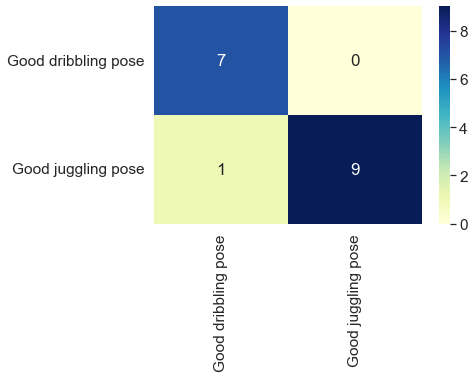

In [84]:
# Visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Good dribbling pose', 'Good juggling pose'], 
                                 index=['Good dribbling pose', 'Good juggling pose'])

sns.set(rc={'figure.figsize':(6, 4)})
sns.set(font_scale=1.4)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#### Classification Report

In [85]:
# Classification report
print(classification_report(actual, predicted))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.90      0.95        10

    accuracy                           0.94        17
   macro avg       0.94      0.95      0.94        17
weighted avg       0.95      0.94      0.94        17



#### Create DataFrame to Plot Training Accuracy and Loss 

In [86]:
standard_cnn_lstm_hist = pd.DataFrame(standard_cnn_lstm_history.history)
standard_cnn_lstm_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,0.693168,0.500,0.692843,0.647059
1,0.692871,0.675,0.692769,0.705882
2,0.692685,0.675,0.692559,0.705882
3,0.692512,0.575,0.692151,0.588235
4,0.692200,0.500,0.691894,0.588235


In [50]:
!mkdir plots

#### Plot Training Accuracy and Loss 

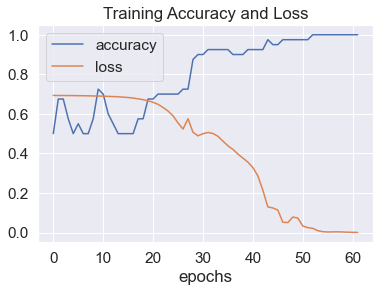

In [87]:
acc_loss = standard_cnn_lstm_hist[["accuracy", "loss"]]
acc_loss.plot(title='Training Accuracy and Loss')
plt.xlabel("epochs")
plt.savefig("plots/Standard CNN-LSTM Training Accuracy and Loss")

#### Plot Validation Accuracy and Loss 

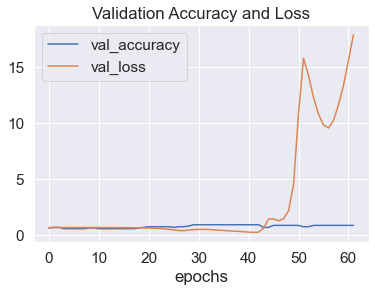

In [88]:
val_acc_loss = standard_cnn_lstm_hist[["val_accuracy", "val_loss"]]
val_acc_loss.plot(title='Validation Accuracy and Loss')
plt.xlabel("epochs")
plt.savefig("plots/Standard CNN-LSTM Validation Accuracy and Loss")

## Save the model

In [53]:
!mkdir saved_encoded_cnn_lstm_model

In [55]:
# standard_cnn_lstm_model.save('saved_encoded_cnn_lstm_model/')

HDF5 Format

In [89]:
standard_cnn_lstm_model.save('saved_encoded_cnn_lstm_model/standard_cnn_lstm_model.h5')

## Hyperparameter Tuning

In [90]:
def tuned_cnn_lstm():    
    input_shape = three_dim_encoded_train_data.shape   
    inputs = keras.Input(shape=(input_shape[1:]))
    
    conv = keras.layers.Conv1D(8, 3, activation='relu')(inputs) 
    # norm = keras.layers.BatchNormalization()(conv)       
    lstm = keras.layers.LSTM(16, return_sequences=True, activation='relu')(conv)
    dropout = keras.layers.Dropout(0.5)(lstm)   
    lstm = keras.layers.LSTM(32, return_sequences=False, activation='relu')(dropout)
    outputs = keras.layers.Dense(1, activation='sigmoid')(lstm)
    tuned_cnn_lstm_model = keras.Model(inputs, outputs)
    
    # Compile the model
    tuned_cnn_lstm_model.compile(
        loss="binary_crossentropy", 
        optimizer=Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )
    
    return tuned_cnn_lstm_model

In [91]:
tuned_cnn_lstm_model = tuned_cnn_lstm()
tuned_cnn_lstm_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 30, 337)]         0         
                                                                 
 conv1d_14 (Conv1D)          (None, 28, 8)             8096      
                                                                 
 lstm_28 (LSTM)              (None, 28, 16)            1600      
                                                                 
 dropout_4 (Dropout)         (None, 28, 16)            0         
                                                                 
 lstm_29 (LSTM)              (None, 32)                6272      
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 16,001
Trainable params: 16,001
Non-trainabl

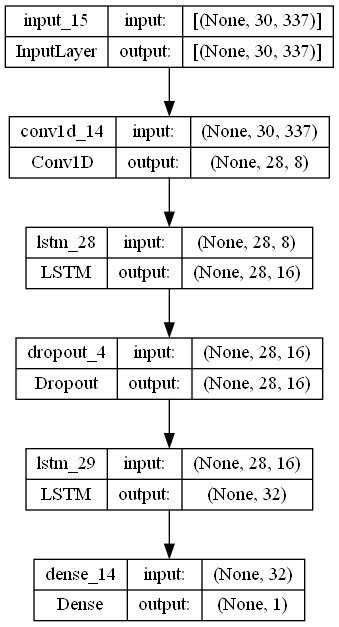

In [92]:
keras.utils.plot_model(tuned_cnn_lstm_model, show_shapes=True)

In [93]:
def run_tuned_experiment():      
    tuned_cnn_lstm_model = tuned_cnn_lstm()     
    
    checkpoint_filepath = "training_cp/cp"
    checkpoint_dir = os.path.dirname(checkpoint_filepath)
    
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True
    )
    
    history = tuned_cnn_lstm_model.fit(
        three_dim_encoded_train_data,
        train_labels, 
        validation_data=(three_dim_encoded_val_data, val_labels),
        epochs=200,
        callbacks=[
            checkpoint_callback,
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
        ]
    )
    
    return history, tuned_cnn_lstm_model

In [94]:
tuned_cnn_lstm_history, tuned_cnn_lstm_model = run_tuned_experiment()

Epoch 1/200
2/2 [==============================] - 4s 632ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.5882
Epoch 2/200
2/2 [==============================] - 0s 80ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6926 - val_accuracy: 0.6471
Epoch 3/200
2/2 [==============================] - 0s 84ms/step - loss: 0.6923 - accuracy: 0.5500 - val_loss: 0.6928 - val_accuracy: 0.4706
Epoch 4/200
2/2 [==============================] - 0s 82ms/step - loss: 0.6923 - accuracy: 0.7500 - val_loss: 0.6931 - val_accuracy: 0.4706
Epoch 5/200
2/2 [==============================] - 0s 86ms/step - loss: 0.6923 - accuracy: 0.5750 - val_loss: 0.6933 - val_accuracy: 0.4118
Epoch 6/200
2/2 [==============================] - 0s 83ms/step - loss: 0.6922 - accuracy: 0.5250 - val_loss: 0.6934 - val_accuracy: 0.4118
Epoch 7/200
2/2 [==============================] - 0s 133ms/step - loss: 0.6924 - accuracy: 0.5000 - val_loss: 0.6934 - val_accuracy: 0.4118
Epoch 8/200
2/2 [=

## Performance Measures

#### Load best model

In [95]:
# Load weights 
tuned_cnn_lstm_model.load_weights(f"training_cp/cp")

In [96]:
loss, acc = tuned_cnn_lstm_model.evaluate(three_dim_encoded_val_data, val_labels, verbose=2)
print("\nBest Accuracy and Loss\n")
print("Accuracy:", f"{round(acc * 100, 2)}%")
print("Loss:", f"{loss}%")

1/1 - 0s - loss: 0.3127 - accuracy: 0.9412 - 33ms/epoch - 33ms/step

Best Accuracy and Loss

Accuracy: 94.12%
Loss: 0.3126513361930847%


#### Make predictions

In [216]:
tuned_preds = tuned_cnn_lstm_model.predict(three_dim_encoded_val_data)

1/1 [==============================] - 0s 104ms/step


In [98]:
actual = val_labels

In [99]:
tuned_predictions = tf.round(tuned_preds)

In [100]:
tuned_cm = confusion_matrix(actual, tuned_predictions)

print('Tuned Confusion matrix\n\n', tuned_cm)

Tuned Confusion matrix

 [[7 0]
 [1 9]]


<AxesSubplot:>

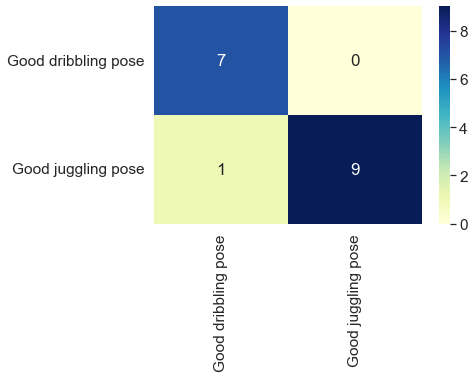

In [101]:
# Visualize confusion matrix with seaborn heatmap

tuned_cm_matrix = pd.DataFrame(data=tuned_cm, columns=['Good dribbling pose', 'Good juggling pose'], 
                                 index=['Good dribbling pose', 'Good juggling pose'])

sns.set(rc={'figure.figsize':(6, 4)})
sns.set(font_scale=1.4)
sns.heatmap(tuned_cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

#### Classification Report for Tuned Hyperparameters

In [102]:
# Classification report
print(classification_report(actual, tuned_predictions))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.90      0.95        10

    accuracy                           0.94        17
   macro avg       0.94      0.95      0.94        17
weighted avg       0.95      0.94      0.94        17



In [103]:
tuned_cnn_lstm_hist = pd.DataFrame(tuned_cnn_lstm_history.history)
tuned_cnn_lstm_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,0.693055,0.500,0.692447,0.588235
1,0.692749,0.500,0.692631,0.647059
2,0.692331,0.550,0.692839,0.470588
3,0.692325,0.750,0.693057,0.470588
4,0.692257,0.575,0.693324,0.411765


## Plot Tuned Training Accuracy and Losse

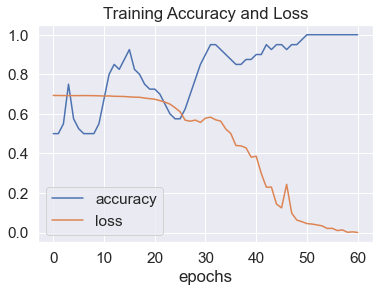

In [104]:
tuned_acc_loss = tuned_cnn_lstm_hist[["accuracy", "loss"]]
tuned_acc_loss.plot(title='Training Accuracy and Loss')
plt.xlabel("epochs")
plt.savefig("plots/Tuned CNN-LSTM Training Accuracy and Loss")

## Plot Tuned Validation Accuracy and Loss

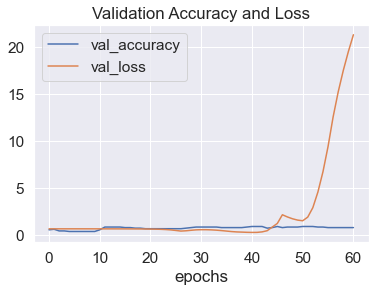

In [105]:
tuned_val_acc_loss = tuned_cnn_lstm_hist[["val_accuracy", "val_loss"]]
tuned_val_acc_loss.plot(title='Validation Accuracy and Loss')
plt.xlabel("epochs")
plt.savefig("plots/Tuned CNN-LSTM Validation Accuracy and Loss")

## Save Tuned Model

In [108]:
# !mkdir saved_tuned_encoded_cnn_lstm_model

Save tuned HDF5 format

In [106]:
tuned_cnn_lstm_model.save('saved_tuned_encoded_cnn_lstm_model/tuned_cnn_lstm_model.h5')